In [1]:
%load_ext autoreload

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from beams import *

import solidspy.assemutil as ass    
import solidspy.solutil as sol      
import solidspy.postprocesor as pos 
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
def is_equilibrium(nodes, mats, els, loads):
    """
    Check if the system is in equilibrium
    
    Get from: https://github.com/AppliedMechanics-EAFIT/SolidsPy/blob/master/solidspy/solids_GUI.py
    
    Parameters
    ----------
    nodes : ndarray
        Array with models nodes
    mats : ndarray
        Array with models materials
    els : ndarray
        Array with models elements
    loads : ndarray
        Array with models loads
        
    Returns
    -------
    equil : bool
        Variable True when the system is in equilibrium and False when it doesn't
    """   

    equil = True
    DME, IBC, neq = ass.DME(nodes, els)
    KG = ass.assembler(els, mats, nodes, neq, DME)
    RHSG = ass.loadasem(loads, IBC, neq)
    UG = sol.static_sol(KG, RHSG)
    
    if not(np.allclose(KG.dot(UG)/KG.max(), RHSG/KG.max())):
        equil = False
    return equil
    
def preprocessing(nodes, mats, els, loads):
    """
    Compute IBC matrix and the static solve.
    
    Get from: https://github.com/AppliedMechanics-EAFIT/SolidsPy/blob/master/solidspy/solids_GUI.py
    
    Parameters
    ----------
    nodes : ndarray
        Array with models nodes
    mats : ndarray
        Array with models materials
    els : ndarray
        Array with models elements
    loads : ndarray
        Array with models loads
        
    Returns
    -------
    IBC : ndarray 
        Boundary conditions array
    UG : ndarray 
        Static displacement solve.
    """   

    # Pre-processing
    DME, IBC, neq = ass.DME(nodes, els)
    print("Number of elements: {}".format(els.shape[0]))

    # System assembly
    KG = ass.assembler(els, mats, nodes, neq, DME)
    RHSG = ass.loadasem(loads, IBC, neq)

    # System solution
    UG = sol.static_sol(KG, RHSG)
    if not(np.allclose(KG.dot(UG)/KG.max(), RHSG/KG.max())):
        print("The system is not in equilibrium!")
    return IBC, UG

def postprocessing(nodes, mats, els, IBC, UG):
    """
    Compute the nodes displacements, strains and stresses.
    
    Get from: https://github.com/AppliedMechanics-EAFIT/SolidsPy/blob/master/solidspy/solids_GUI.py
    
    Parameters
    ----------
    nodes : ndarray
        Array with models nodes
    mats : ndarray
        Array with models materials
    els : ndarray
        Array with models elements
    IBC : ndarray 
        Boundary conditions array
    UG : ndarray 
        Static solve.
        
    Returns
    -------
    UC : ndarray 
        Displacements at elements.
    E_nodes : ndarray 
        Strains at elements.
    S_nodes : ndarray 
        Stresses at elements.
    """   
    
    UC = pos.complete_disp(IBC, nodes, UG)
    E_nodes, S_nodes = None, None
    E_nodes, S_nodes = pos.strain_nodes(nodes , els, mats, UC)
    
    return UC, E_nodes, S_nodes


In [4]:
def strain_els(els, E_nodes, S_nodes):
    """
    Compute the elements strains and stresses.
    
    Get from: https://github.com/AppliedMechanics-EAFIT/SolidsPy/blob/master/solidspy/solids_GUI.py
    
    Parameters
    ----------
    els : ndarray
        Array with models elements
    E_nodes : ndarray
        Strains at nodes.
    S_nodes : ndarray
        Stresses at nodes.
        
    Returns
    -------
    E_els : ndarray (nnodes, 3)
        Strains at elements.
    S_els : ndarray (nnodes, 3)
        Stresses at elements.
    """   
    
    E_els = []
    S_els = []
    for el in els:
        strain_nodes = np.take(E_nodes, list(el[3:]), 0)
        stress_nodes = np.take(S_nodes, list(el[3:]), 0)
        strain_elemt = (strain_nodes[0] + strain_nodes[1] + strain_nodes[2] + strain_nodes[3]) / 4
        stress_elemt = (stress_nodes[0] + stress_nodes[1] + stress_nodes[2] + stress_nodes[3]) / 4
        E_els.append(strain_elemt)
        S_els.append(stress_elemt)
    E_els = np.array(E_els)
    S_els = np.array(S_els)
    
    return E_els, S_els

def protect_els(els, loads, BC):
    """
    Compute an mask array with the elements that don't must be deleted.
    
    Get from: https://github.com/AppliedMechanics-EAFIT/SolidsPy/blob/master/solidspy/solids_GUI.py
    
    Parameters
    ----------
    els : ndarray
        Array with models elements
    loads : ndarray
        Array with models loads
    BC : ndarray 
        Boundary conditions nodes
        
    Returns
    -------
    mask_els : ndarray 
        Array with the elements that don't must be deleted.
    """   
    mask_els = np.ones_like(els[:,0], dtype=bool)
    protect_nodes = np.hstack((loads[:,0], BC)).astype(int)
    protect_index = None
    for p in protect_nodes:
        protect_index = np.argwhere(els[:, -4:] == p)[:,0]
        mask_els[protect_index] = False
        
    return mask_els

def del_node(nodes, els):
    """
    Retricts nodes dof that aren't been used.
    
    Get from: https://github.com/AppliedMechanics-EAFIT/SolidsPy/blob/master/solidspy/solids_GUI.py
    
    Parameters
    ----------
    nodes : ndarray
        Array with models nodes
    els : ndarray
        Array with models elements

    Returns
    -------
    """   
    n_nodes = nodes.shape[0]
    for n in range(n_nodes):
        if n not in els[:, -4:]:
            nodes[n, -2:] = -1

In [5]:
nodes, mats, els, loads, BC = beam_2(L=10, H=24, nx=20, ny=40)
elsI,nodesI = np.copy(els), np.copy(nodes)

In [6]:
IBC, UG = preprocessing(nodes, mats, els, loads)
UCI, E_nodesI, S_nodesI = postprocessing(nodes, mats, els, IBC, UG)

Number of elements: 800


In [7]:
niter = 20
RR = 0.01
ER = 0.03
V_opt = int(len(els) * 0.50)

ELS = None
for _ in range(niter):
    if not is_equilibrium(nodes, mats, els, loads) or len(els) < V_opt: break
    
    IBC, UG = preprocessing(nodes, mats, els, loads)
    UC, E_nodes, S_nodes = postprocessing(nodes, mats, els, IBC, UG)
    E_els, S_els = strain_els(els, E_nodes, S_nodes)
    vons = np.sqrt(S_els[:,0]**2 - (S_els[:,0]*S_els[:,1]) + S_els[:,1]**2 + 3*S_els[:,2]**2)
    RR_el = vons/vons.max()
    mask_del = RR_el < RR
    mask_els = protect_els(els, loads, BC)
    mask_del *= mask_els
    ELS = els
    
    els = np.delete(els, mask_del, 0)
    del_node(nodes, els)
    RR += ER
print(RR)

Number of elements: 800
Number of elements: 788
Number of elements: 770
Number of elements: 762
Number of elements: 754
Number of elements: 740
Number of elements: 728
Number of elements: 713
Number of elements: 703
Number of elements: 692
Number of elements: 680
Number of elements: 659
Number of elements: 632
Number of elements: 583
Number of elements: 531
Number of elements: 505
Number of elements: 470
Number of elements: 445
Number of elements: 401
0.5800000000000003


c:\Users\santy\anaconda3\envs\femenv2\Lib\site-packages\solidspy\postprocesor.py:108: UserWarning: The following kwargs were not used by contour: 'shading'
  disp_plot(tri, field, levels, shading="gouraud")


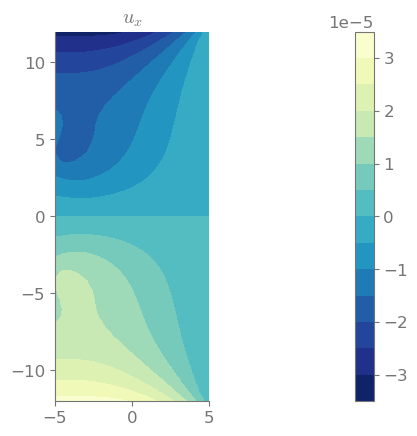

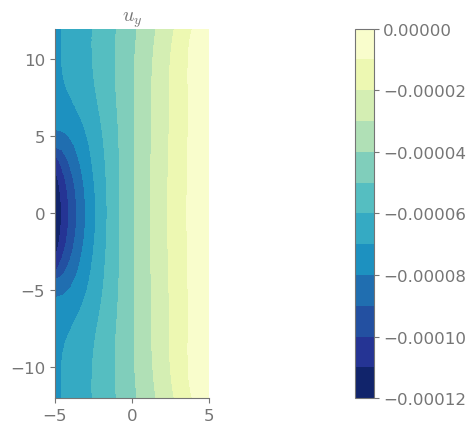

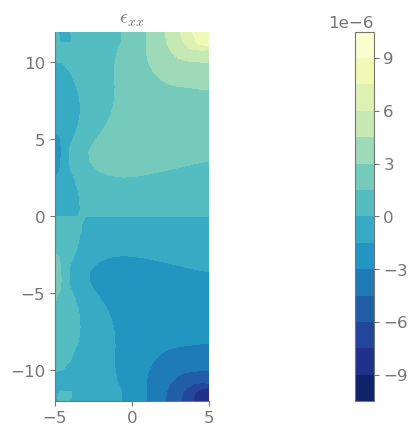

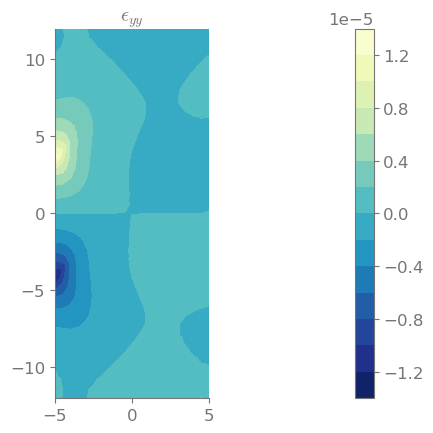

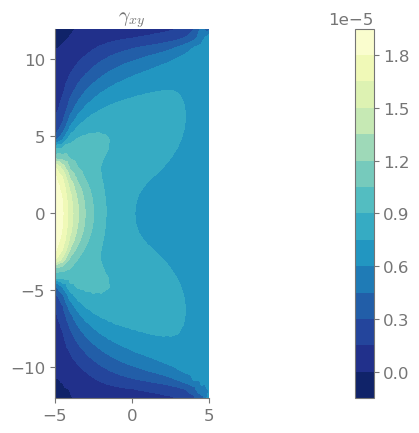

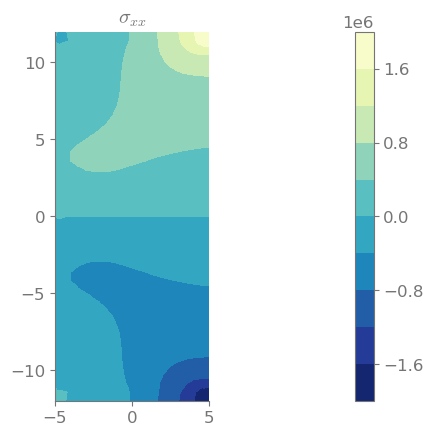

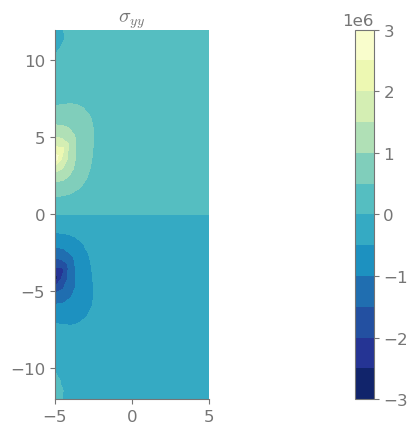

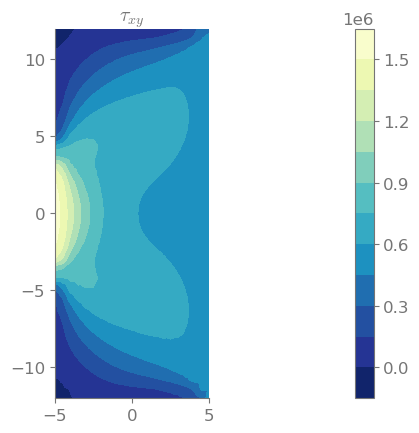

In [8]:
pos.fields_plot(elsI, nodes, UCI, E_nodes=E_nodesI, S_nodes=S_nodesI)

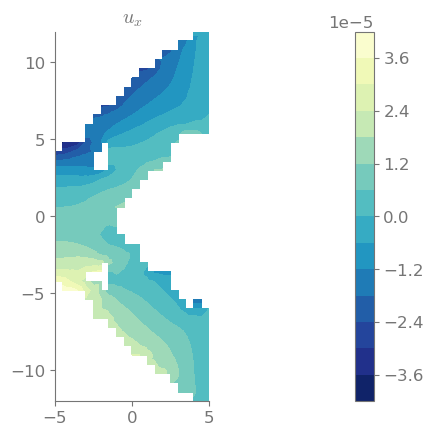

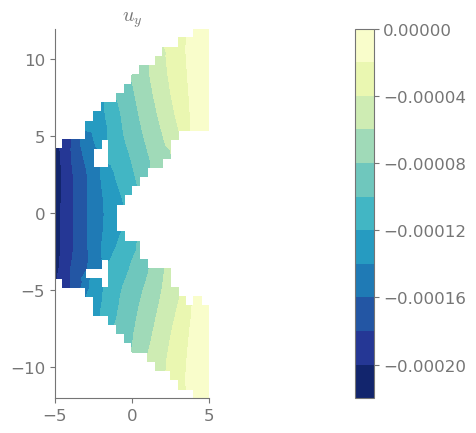

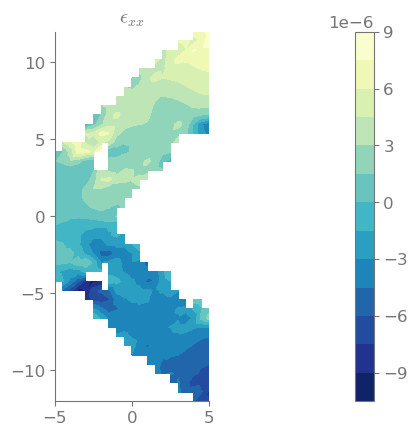

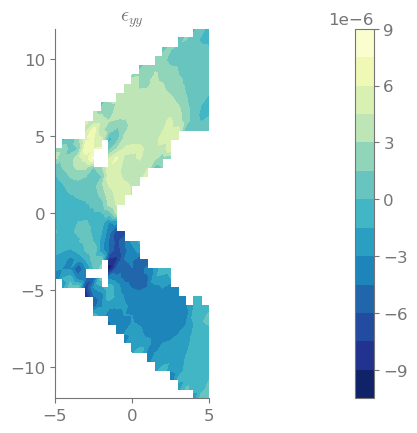

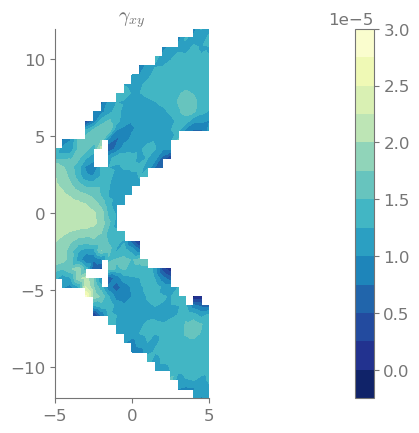

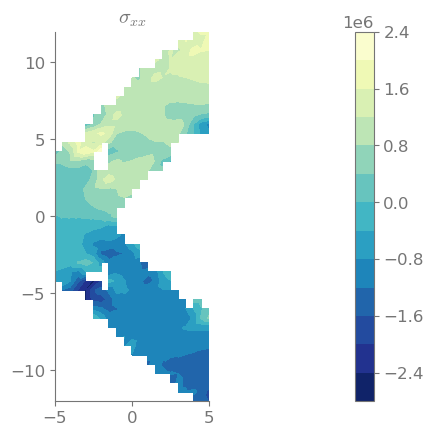

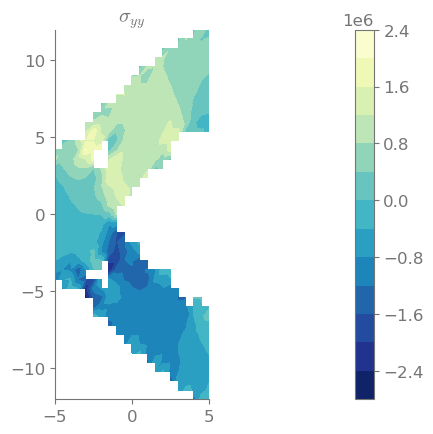

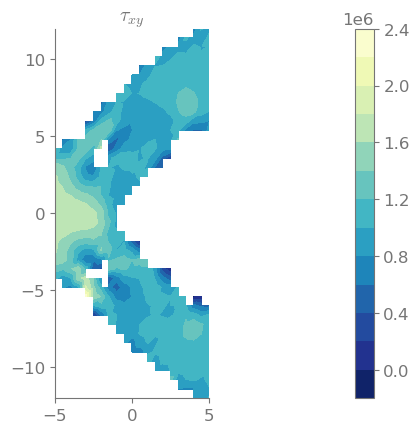

In [9]:
pos.fields_plot(ELS, nodes, UC, E_nodes=E_nodes, S_nodes=S_nodes)